In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import shutil
from datetime import datetime
from nrt_wind.wind import read_wind_mag
from nrt_wind.Pre_processing import create_hodogram_realFR_t_minus_24hr
from nrt_wind.DeepFRi_test import cnn_model_fit_10_60
from nrt_wind.Post_processing import prepare_pre_list
from nrt_wind.Post_processing import boundary_finding
from nrt_wind.Post_processing import boundary_w_bth
from nrt_wind.DicFR_test import DicFR

In [2]:
imgPath='./nrt_wind/test/'

Applying DeepFRi and DiFR models on real solar wind time series and deriving list of FRs with start and end boundaries and geoeffectiveness.

In [5]:


path = os.path.join(imgPath, 'bx_by')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
path = os.path.join(imgPath, 'bx_bz')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
path = os.path.join(imgPath, 'bz_by')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)

path = os.path.join(imgPath, 'concat')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
#####........................Start and end time during which users would like to search for FRs..........................
st='2023-12-16 00:00:00'
et='2023-12-16 01:00:00'

#####........................Pre-processing and preparing hodograms............................................

create_hodogram_realFR_t_minus_24hr(st,et,imgPath)






Applying DeepFRi model

In [4]:
#####........................Applying DeepFRi model............................................
output='nrt_result10_60_test.txt'
file=imgPath+output
cnn_model_fit_10_60(imgPath,file)



2024-05-27 15:41:38.247430: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-27 15:41:38.247505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


27
1/1 [==============================] - 0s 16ms/step


Preparing List1, List2 and Final List

/Users/spal1/Documents/AI_ML/DeepFRi-and-DicFR-main/nrt_wind/Post_processing.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(imgPath+inputfile, sep=" |'", header=None)
/Users/spal1/Documents/AI_ML/DeepFRi-and-DicFR-main/nrt_wind/Post_processing.py:85: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfr = pd.read_csv(imgPath+inputfile, sep=" |'", header=None)


1




2023-12-15 23:02:24 2023-12-16 22:14:24


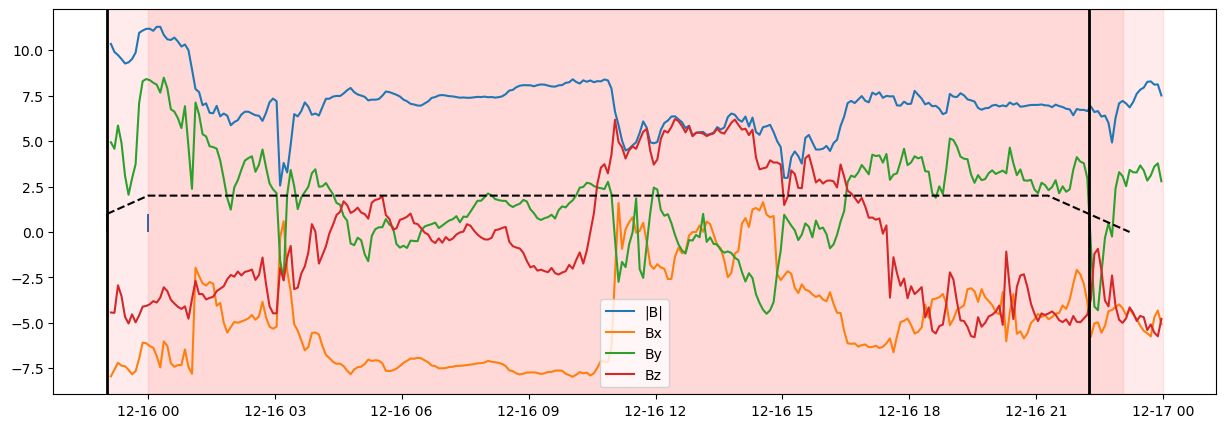

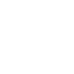

In [4]:
#####........................Preparing List1, List2 and Final List ............................................

prepare_pre_list(imgPath,'nrt_result10_60_test.txt','List1_prime.txt')
outfile1='List1.txt'
outfile2= 'List2.txt'
if os.path.getsize(imgPath+'List1_prime.txt') == 0:
        print('no FRs')
else:  
    df= pd.read_csv(imgPath+'List1_prime.txt', sep=" ", header=None)
    list1= open(imgPath+outfile1, 'w')
    for i in df.index:
        tstart=df[0][i]+' '+df[1][i]
        tend=df[2][i]+' '+df[3][i]
        boundary_finding(imgPath,'nrt_result10_60_test.txt',tstart,tend,list1)
    list1.close() 

if os.path.getsize(imgPath+outfile1) == 0:
        print('no FRs')
else:  
    df= pd.read_csv(imgPath+outfile1, sep=" ", header=None)
    list2= open(imgPath+outfile2, 'w')
    for i in df.index:
        tstart=df[0][i]+' '+df[1][i]
        tend=df[2][i]+' '+df[3][i]
        boundary_w_bth(tstart,tend,list2)
    list2.close()

#####........................Applying DiFR model and create the Final list............................................
finallist='Final_list.txt'
DicFR(imgPath,outfile2,finallist)

Plotting FRs embeded in solar wind data.

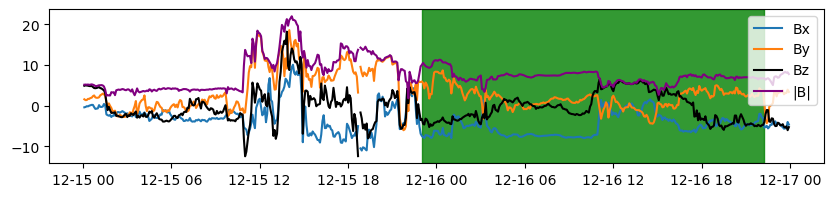

In [5]:
st='2023-12-16 00:00:00'
et='2023-12-16 01:00:00'
l=5
window_duration=24 #in hours
npoint=int(np.round(window_duration*60./l)) 

tts=pd.to_datetime((datetime.strptime(str(st), "%Y-%m-%d %H:%M:%S")-datetime(1970, 1, 1, 0, 0)).total_seconds()-l*npoint*60.,unit='s')
tte=pd.to_datetime((datetime.strptime(str(st), "%Y-%m-%d %H:%M:%S")-datetime(1970, 1, 1, 0, 0)).total_seconds()+l*npoint*60.,unit='s')

df= read_wind_mag( tts,tte)
bxn=df.Bx.rolling(window=l,step=l).mean()
byn=df.By.rolling(window=l,step=l).mean()
bzn=df.Bz.rolling(window=l,step=l).mean()  
plt.figure(figsize=(10, 2))
plt.plot(bxn,label='Bx')
plt.plot(byn,label='By')
plt.plot(bzn,label='Bz',color='k')
plt.plot(np.sqrt(bxn*bxn+byn*byn+bzn*bzn),label='|B|',color='purple')
plt.legend()
if os.path.getsize(imgPath+'List2.txt') != 0:
     df_list2= pd.read_csv(imgPath+'List2.txt', sep=" ", header=None)
     for i in df_list2.index:
          FR_s_l2=pd.to_datetime(df_list2[0][i]+' '+df_list2[1][i])
          FR_e_l2=pd.to_datetime(df_list2[2][i]+' '+df_list2[3][i])
          plt.axvspan(FR_s_l2,FR_e_l2, ymin=0, ymax=1, alpha=0.8, color='green')
if os.path.getsize(imgPath+'Final_list.txt') != 0:
     for i in df_list2.index:
          df_final= pd.read_csv(imgPath+'Final_list.txt', sep=" ", header=None)
          FR_s=pd.to_datetime(df_final[0][i]+' '+df_final[1][i])
          FR_e=pd.to_datetime(df_final[2][i]+' '+df_final[3][i])
          if df_final[4][i]!=0:
               plt.axvspan(FR_s,FR_e, ymin=0, ymax=1, alpha=0.8, color='red')
